In [124]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score
from pandas.api.types import is_string_dtype,is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

In [125]:
path ='C:\\Users\\neell\\Documents\\DataScience\\Module7'

In [126]:
my_df = pd.read_csv(f'{path}\Titanic.csv')
print(my_df.shape)
my_df.head(2)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## Splitting Data

In [127]:
def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


mydf_train_valid,mydf_test = mydf_splitter(my_df,1150)

print(mydf_train_valid.shape,mydf_test.shape)

(1150, 12) (159, 12)


## Finding Null Values

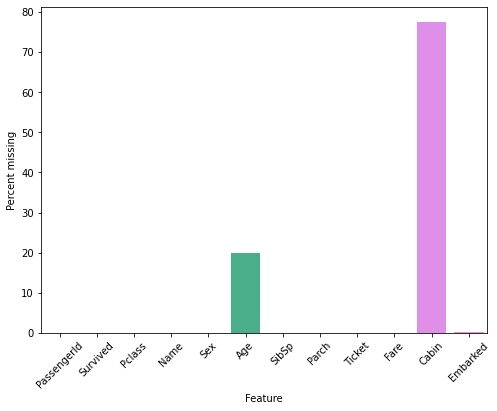

In [128]:
null_vals = mydf_train_valid.isnull().sum()/len(mydf_train_valid)*100
null_vals = pd.DataFrame(null_vals)

null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
null_vals
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

## Preprocessing Data and apriori feature selection 

### Imputation 1
### Computing age missing values based on title of Names and adding new Title column 

In [129]:
mydf_train_valid['Title'] = mydf_train_valid['Name'].str.extract('([A-Za-z]+)\.', expand=True)

In [130]:
mydf_train_valid['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

In [131]:
# replace rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
mydf_train_valid.replace({'Title': mapping}, inplace=True)

In [132]:
print(mydf_train_valid['Title'].unique())
mydf_train_valid['Title'].value_counts()

['Mr' 'Mrs' 'Miss' 'Master' 'Rev' 'Dr']


Mr        672
Miss      235
Mrs       176
Master     52
Rev         8
Dr          7
Name: Title, dtype: int64

In [133]:
##imputing the age missing values by using the median age for all people that belong to same Title

In [134]:

title_ages = dict(mydf_train_valid.groupby('Title')['Age'].median())
title_ages


{'Dr': 46.5, 'Master': 4.0, 'Miss': 22.0, 'Mr': 30.0, 'Mrs': 35.0, 'Rev': 41.5}

In [135]:
# create a column of the average ages
mydf_train_valid['age_med'] = mydf_train_valid['Title'].apply(lambda x: title_ages[x])
print(mydf_train_valid['age_med'].groupby(mydf_train_valid['Title']).count())
mydf_train_valid.head()


Title
Dr          7
Master     52
Miss      235
Mr        672
Mrs       176
Rev         8
Name: age_med, dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,age_med
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,30.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,35.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,22.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,30.0


In [136]:
# replace all missing ages with the value in this column and remove age_med after 
mydf_train_valid['Age'].fillna(mydf_train_valid['age_med'], inplace=True, )
del mydf_train_valid['age_med']
mydf_train_valid.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [137]:
##NO NULL VALUES IN AGE
mydf_train_valid['Age'].isnull().value_counts()

False    1150
Name: Age, dtype: int64

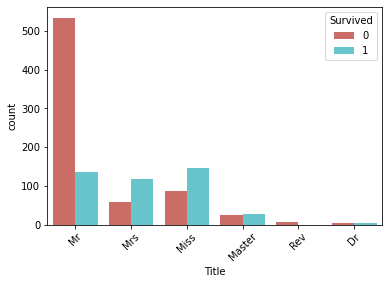

In [138]:
sns.countplot(x='Title', data=mydf_train_valid, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

### Imputation 2
### Impute missing fare values

In [139]:
mydf_train_valid['Fare'].isnull().value_counts()

False    1149
True        1
Name: Fare, dtype: int64

In [140]:
mydf_train_valid[mydf_train_valid['Fare'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1043,1044,0,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr


In [141]:
# impute missing Fare values using median of Pclass groups
class_fares = dict(mydf_train_valid.groupby('Pclass')['Fare'].median())
class_fares

{1: 59.4, 2: 15.0458, 3: 8.05}

In [142]:
# create a column of the average fares
mydf_train_valid['fare_med'] = mydf_train_valid['Pclass'].apply(lambda x: class_fares[x])
mydf_train_valid.loc[(mydf_train_valid['PassengerId']==1044)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,fare_med
1043,1044,0,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,Mr,8.05


In [143]:
# replace all missing fares with the value in this column
mydf_train_valid['Fare'].fillna(mydf_train_valid['fare_med'], inplace=True, )
del mydf_train_valid['fare_med']

In [144]:
##missing nan value is been replaced 
mydf_train_valid.loc[(mydf_train_valid['PassengerId']==1044)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1043,1044,0,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,8.05,NaN,S,Mr


In [145]:
mydf_train_valid['Fare'].isnull().value_counts()

False    1150
Name: Fare, dtype: int64

### IMPUTE 3
### Parch and SibSp can be combined to create a new variable called Family_Size.

In [146]:
mydf_train_valid['Family_Size'] = mydf_train_valid['Parch'] + mydf_train_valid['SibSp']
mydf_train_valid.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0


In [147]:
mydf_train_valid['Family_Size'].describe()

count    1150.000000
mean        0.888696
std         1.575971
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        10.000000
Name: Family_Size, dtype: float64

In [148]:
mydf_train_valid.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0


### Imputation 4
### MAPPING SEX BASED ON AGE AND REPLACING IT WITH INTEGER CATEGORICAL VALUES

In [149]:
mydf_train_valid_3 = mydf_train_valid_2.copy()

In [150]:
mydf_train_valid_3.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Family_Size
0,1,0,3,male,22.0,7.2500,3,1
1,2,1,1,female,38.0,71.2833,1,1
2,3,1,3,female,26.0,7.9250,3,0
3,4,1,1,female,35.0,53.1000,3,1
4,5,0,3,male,35.0,8.0500,3,0


In [151]:
mydf_train_valid_3['age_group'] = pd.cut(mydf_train_valid.Age, range(0, 81,20), right=False)
mydf_train_valid_3.head(5)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Family_Size,age_group
0,1,0,3,male,22.0,7.2500,3,1,"[20, 40)"
1,2,1,1,female,38.0,71.2833,1,1,"[20, 40)"
2,3,1,3,female,26.0,7.9250,3,0,"[20, 40)"
3,4,1,1,female,35.0,53.1000,3,1,"[20, 40)"
4,5,0,3,male,35.0,8.0500,3,0,"[20, 40)"


In [152]:
###mydf_train_valid_3['Survived'].groupby(mydf_train_valid_3['age_group']).value_counts()
mydf_train_valid_3.groupby(['Survived' ,'age_group','Sex']).size()

Survived  age_group  Sex   
0         [0, 20)    female     34
                     male       79
          [20, 40)   female     89
                     male      377
          [40, 60)   female     18
                     male       93
          [60, 80)   female      6
                     male       22
1         [0, 20)    female     57
                     male       36
          [20, 40)   female    160
                     male      100
          [40, 60)   female     44
                     male       24
          [60, 80)   female      4
                     male        6
dtype: int64

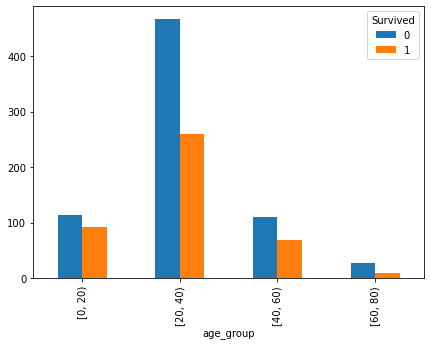

In [153]:
fig, ax = plt.subplots(figsize=(7,5))
mydf_train_valid_3.groupby(['age_group','Survived']).count()['Sex'].unstack().plot(ax=ax,kind = 'bar')

In [154]:
##From above age < 20 has more survival rate and drop age_group

In [155]:
mydf_train_valid_3=mydf_train_valid_3.drop(["age_group"],axis = 1)
mydf_train_valid_3.head(2)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Family_Size
0,1,0,3,male,22.0,7.2500,3,1
1,2,1,1,female,38.0,71.2833,1,1


In [156]:
## Adding Sex_CFM column and Set Age < 20 as Child

In [157]:
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 20 else sex
    


In [158]:
mydf_train_valid_3['Sex_CFM'] = mydf_train_valid_3[['Age','Sex']].apply(get_person,axis=1)
mydf_train_valid_3[(mydf_train_valid_3['Sex_CFM']=='child')].head(2)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Family_Size,Sex_CFM
7,8,0,3,male,2.0,21.0750,3,4,child
9,10,1,2,female,14.0,30.0708,1,1,child


In [159]:
mydf_train_valid_3.drop(['Sex'],axis=1,inplace=True)
mydf_train_valid_3.head(3)

,PassengerId,Survived,Pclass,Age,Fare,Embarked,Family_Size,Sex_CFM
0,1,0,3,22.0,7.2500,3,1,male
1,2,1,1,38.0,71.2833,1,1,female
2,3,1,3,26.0,7.9250,3,0,female


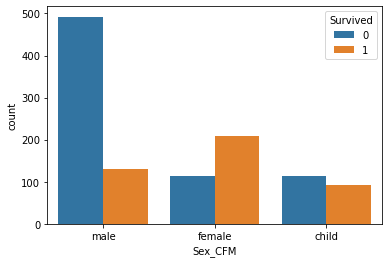

In [160]:
sns.countplot(mydf_train_valid_3['Sex_CFM'], hue=mydf_train_valid_3['Survived'])

In [161]:
mydf_train_valid_3= mydf_train_valid_3.replace({'Sex_CFM' : {"child":0,"male" :'2' ,'female' : '1'}})

In [162]:
mydf_train_valid_3 = str_to_cat(mydf_train_valid_3)

In [163]:
mydf_train_valid_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1150 non-null   int64   
 1   Survived     1150 non-null   int64   
 2   Pclass       1150 non-null   int64   
 3   Age          1150 non-null   float64 
 4   Fare         1150 non-null   float64 
 5   Embarked     1150 non-null   int64   
 6   Family_Size  1150 non-null   int64   
 7   Sex_CFM      1150 non-null   category
dtypes: category(1), float64(2), int64(5)
memory usage: 64.2 KB


In [164]:

print(mydf_train_valid_3.Sex_CFM.cat.categories)

Index([0, '1', '2'], dtype='object')


In [165]:
mydf_train_valid_3.head(10)

,PassengerId,Survived,Pclass,Age,Fare,Embarked,Family_Size,Sex_CFM
0,1,0,3,22.0,7.2500,3,1,2
1,2,1,1,38.0,71.2833,1,1,1
2,3,1,3,26.0,7.9250,3,0,1
3,4,1,1,35.0,53.1000,3,1,1
4,5,0,3,35.0,8.0500,3,0,2
5,6,0,3,30.0,8.4583,2,0,2
6,7,0,1,54.0,51.8625,3,0,2
7,8,0,3,2.0,21.0750,3,4,0
8,9,1,3,27.0,11.1333,3,2,1
9,10,1,2,14.0,30.0708,1,1,0


In [166]:
##No null values
mydf_train_valid_3.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Age            0
Fare           0
Embarked       0
Family_Size    0
Sex_CFM        0
dtype: int64

##### SPLITTING DATA

In [167]:
x = mydf_train_valid_3.drop('Survived', axis=1)
y = mydf_train_valid_3['Survived']
print(pd.DataFrame(y).head(2))
x.shape,y.shape

   Survived
0         0
1         1


((1150, 7), (1150,))

In [168]:
x_trn, x_val, y_trn, y_val = train_test_split(x, y, random_state=1)    ### test_size=0.3
print(x_trn.shape,x_val.shape,y_trn.shape,y_val.shape)

(862, 7) (288, 7) (862,) (288,)


### Random Forest

In [169]:
mod_1 = RandomForestClassifier(n_jobs = -1, n_estimators = 10,
                                 bootstrap = True)
mod_1.fit(x_trn,y_trn)

RandomForestClassifier(n_estimators=10, n_jobs=-1)

In [170]:
y_prd = mod_1.predict(x_val)
accuracy_score(y_val,y_prd)

0.7118055555555556

In [171]:
mod_2 = RandomForestClassifier(random_state=42,n_jobs = -1, n_estimators = 1000,
                                 bootstrap = True)
mod_2.fit(x_trn,y_trn)
y_prd2 = mod_2.predict(x_val)
a =accuracy_score(y_val,y_prd2)
(round(a,2)*100 ,"%")

(74.0, '%')

In [172]:
mod_3 = RandomForestClassifier(random_state=100,n_jobs = -1, n_estimators = 1000,max_features = 0.25,
                               bootstrap = True)
mod_3.fit(x_trn,y_trn)
y_prd3 = mod_3.predict(x_val)
accuracy_score(y_val,y_prd3)

0.7430555555555556

##### GRID SEARCH

In [173]:
from sklearn.model_selection import GridSearchCV

In [174]:
param_grid = { 
    'n_estimators': [1200,1500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
    }

In [175]:
mod_4 = RandomForestClassifier(random_state=42)

In [176]:
CV_rfc = GridSearchCV(estimator=mod_4, param_grid=param_grid, cv= 5)

In [177]:
#20 min approx
CV_rfc.fit(x_trn,y_trn)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [1200, 1500]})

In [178]:
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 'auto',
 'n_estimators': 1200}

In [179]:
mod_5 = RandomForestClassifier(random_state=42 ,criterion= 'entropy',
                               max_depth= 7,max_features='auto',
                               n_estimators= 1200)

In [180]:
mod_5.fit(x_trn,y_trn)

RandomForestClassifier(criterion='entropy', max_depth=7, n_estimators=1200,
                       random_state=42)

In [181]:
y_prd5 = mod_5.predict(x_val)
accuracy_score(y_val,y_prd5)

0.7361111111111112

### Feature importance

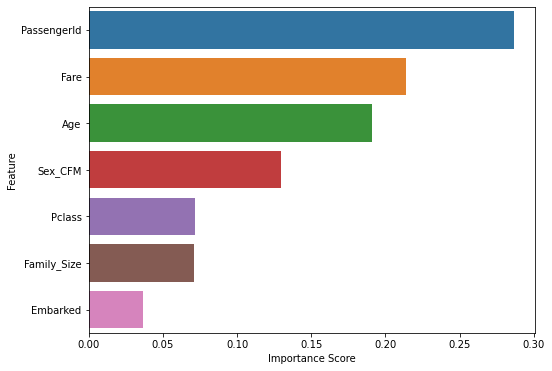

In [182]:
'''Calculate feature importance scores with your model'''

feat_imps = pd.DataFrame(mod_2.feature_importances_, index = x_trn.columns,
                                    columns=['Importance score']).sort_values('Importance score',ascending=False)
feat_imps = feat_imps.reset_index()
feat_imps.columns = ["Feature","Importance Score"]
plt.figure(figsize = (8,6))
sns.barplot(x = "Importance Score",y = "Feature",data = feat_imps,orient = "h")

## TESTING

In [183]:
print(mydf_test.shape)
mydf_test.head(4)

(159, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1150,1151,1,3,"Midtsjo, Mr. Karl Albert",male,21.0,0,0,345501,7.7750,NaN,S
1151,1152,0,3,"de Messemaeker, Mr. Guillaume Joseph",male,36.5,1,0,345572,17.4000,NaN,S
1152,1153,1,3,"Nilsson, Mr. August Ferdinand",male,21.0,0,0,350410,7.8542,NaN,S
1153,1154,0,2,"Wells, Mrs. Arthur Henry (Addie"" Dart Trevaskis)""",female,29.0,0,2,29103,23.0000,NaN,S


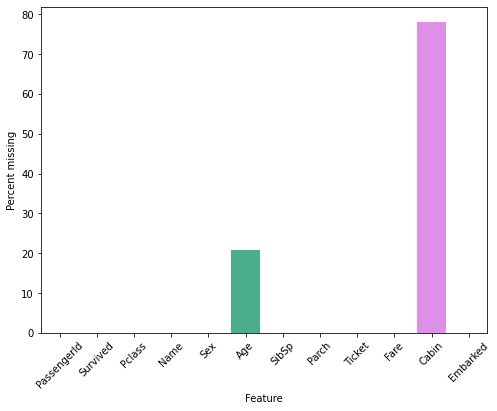

In [184]:
null_vals1 = mydf_test.isnull().sum()/len(mydf_test)*100
null_vals1 = pd.DataFrame(null_vals1)

null_vals1.reset_index(inplace = True)
null_vals1.columns = ["Feature","Percent missing"]
null_vals1
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals1)

In [185]:
mydf_test['Age'].isnull().value_counts()

False    126
True      33
Name: Age, dtype: int64

In [186]:
mydf_test_1 =mydf_test.copy()

In [187]:
mydf_test_1['Title'] = mydf_test_1['Name'].str.extract('([A-Za-z]+)\.', expand=True)

In [188]:
mydf_test_1.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1150,1151,1,3,"Midtsjo, Mr. Karl Albert",male,21.0,0,0,345501,7.775,NaN,S,Mr
1151,1152,0,3,"de Messemaeker, Mr. Guillaume Joseph",male,36.5,1,0,345572,17.400,NaN,S,Mr


In [189]:
mydf_test_1['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Dr', 'Dona'], dtype=object)

In [190]:
# replace rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr',
           'Don': 'Mr', 'Mme': 'Mrs', 'Jonkheer': 'Mr', 'Lady': 'Mrs',
           'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
mydf_test_1.replace({'Title': mapping}, inplace=True)

In [191]:
print(mydf_test_1['Title'].unique())
mydf_test_1['Title'].value_counts()

['Mr' 'Mrs' 'Miss' 'Master' 'Dr']


Mr        95
Miss      29
Mrs       25
Master     9
Dr         1
Name: Title, dtype: int64

In [192]:
##imputing the age missing values by using the median age for all people that belong to same Title

In [193]:

title_ages = dict(mydf_test_1.groupby('Title')['Age'].median())
title_ages


{'Dr': 53.0, 'Master': 5.5, 'Miss': 22.0, 'Mr': 28.0, 'Mrs': 39.0}

In [194]:
# create a column of the average ages
mydf_test_1['age_med'] = mydf_test_1['Title'].apply(lambda x: title_ages[x])
print(mydf_test_1['age_med'].groupby(mydf_test_1['Title']).count())
mydf_test_1.head()


Title
Dr         1
Master     9
Miss      29
Mr        95
Mrs       25
Name: age_med, dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,age_med
1150,1151,1,3,"Midtsjo, Mr. Karl Albert",male,21.0,0,0,345501,7.7750,NaN,S,Mr,28.0
1151,1152,0,3,"de Messemaeker, Mr. Guillaume Joseph",male,36.5,1,0,345572,17.4000,NaN,S,Mr,28.0
1152,1153,1,3,"Nilsson, Mr. August Ferdinand",male,21.0,0,0,350410,7.8542,NaN,S,Mr,28.0
1153,1154,0,2,"Wells, Mrs. Arthur Henry (Addie"" Dart Trevaskis)""",female,29.0,0,2,29103,23.0000,NaN,S,Mrs,39.0
1154,1155,0,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,Miss,22.0


In [195]:
# replace all missing ages with the value in this column and remove age_med after 
mydf_test_1['Age'].fillna(mydf_test_1['age_med'], inplace=True, )
del mydf_test_1['age_med']
mydf_test_1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1150,1151,1,3,"Midtsjo, Mr. Karl Albert",male,21.0,0,0,345501,7.7750,NaN,S,Mr
1151,1152,0,3,"de Messemaeker, Mr. Guillaume Joseph",male,36.5,1,0,345572,17.4000,NaN,S,Mr
1152,1153,1,3,"Nilsson, Mr. August Ferdinand",male,21.0,0,0,350410,7.8542,NaN,S,Mr
1153,1154,0,2,"Wells, Mrs. Arthur Henry (Addie"" Dart Trevaskis)""",female,29.0,0,2,29103,23.0000,NaN,S,Mrs
1154,1155,0,3,"Klasen, Miss. Gertrud Emilia",female,1.0,1,1,350405,12.1833,NaN,S,Miss


In [196]:
##NO NULL VALUES IN AGE
mydf_test_1['Age'].isnull().value_counts()

False    159
Name: Age, dtype: int64

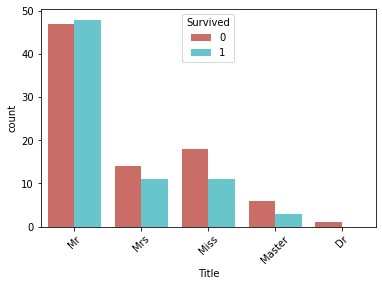

In [197]:
sns.countplot(x='Title', data=mydf_test_1, palette='hls', hue='Survived')
plt.xticks(rotation=45)
plt.show()

In [198]:
mydf_test_1.isnull().count()

PassengerId    159
Survived       159
Pclass         159
Name           159
Sex            159
Age            159
SibSp          159
Parch          159
Ticket         159
Fare           159
Cabin          159
Embarked       159
Title          159
dtype: int64

In [199]:
mydf_test_1['Family_Size'] = mydf_test_1['Parch'] + mydf_test_1['SibSp']
mydf_test_1.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family_Size
1150,1151,1,3,"Midtsjo, Mr. Karl Albert",male,21.0,0,0,345501,7.7750,NaN,S,Mr,0
1151,1152,0,3,"de Messemaeker, Mr. Guillaume Joseph",male,36.5,1,0,345572,17.4000,NaN,S,Mr,1
1152,1153,1,3,"Nilsson, Mr. August Ferdinand",male,21.0,0,0,350410,7.8542,NaN,S,Mr,0


In [200]:
mydf_test_1['Family_Size'].describe()

count    159.000000
mean       0.849057
std        1.642739
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       10.000000
Name: Family_Size, dtype: float64

In [201]:
mydf_test_1=mydf_test_1.drop(["Name","Cabin","Ticket","SibSp","Parch","Title"],axis = 1)


In [202]:
mydf_test_1.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Family_Size
1150,1151,1,3,male,21.0,7.7750,S,0
1151,1152,0,3,male,36.5,17.4000,S,1
1152,1153,1,3,male,21.0,7.8542,S,0
1153,1154,0,2,female,29.0,23.0000,S,2
1154,1155,0,3,female,1.0,12.1833,S,2


In [203]:
mydf_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 1150 to 1308
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  159 non-null    int64  
 1   Survived     159 non-null    int64  
 2   Pclass       159 non-null    int64  
 3   Sex          159 non-null    object 
 4   Age          159 non-null    float64
 5   Fare         159 non-null    float64
 6   Embarked     159 non-null    object 
 7   Family_Size  159 non-null    int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 10.1+ KB


In [204]:


def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [205]:
mydf_test_2 = str_to_cat(mydf_test_1)
print(mydf_test_2.shape)
mydf_test_2.head()

(159, 8)


,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Family_Size
1150,1151,1,3,male,21.0,7.7750,S,0
1151,1152,0,3,male,36.5,17.4000,S,1
1152,1153,1,3,male,21.0,7.8542,S,0
1153,1154,0,2,female,29.0,23.0000,S,2
1154,1155,0,3,female,1.0,12.1833,S,2


In [206]:
mydf_test_2.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 1150 to 1308
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  159 non-null    int64   
 1   Survived     159 non-null    int64   
 2   Pclass       159 non-null    int64   
 3   Sex          159 non-null    category
 4   Age          159 non-null    float64 
 5   Fare         159 non-null    float64 
 6   Embarked     159 non-null    category
 7   Family_Size  159 non-null    int64   
dtypes: category(2), float64(2), int64(4)
memory usage: 8.1 KB


In [207]:
mydf_test_2.Embarked.cat.categories

Index(['C', 'Q', 'S'], dtype='object')

In [208]:
mydf_test_2= mydf_test_2.replace({'Embarked' : {"C": 1, "Q": 2, "S": 3}})

In [209]:
mydf_test_2['Embarked'].unique()

array([3, 1, 2], dtype=int64)

In [210]:
mydf_test_3 = mydf_test_2.copy()

In [211]:
mydf_test_3.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Family_Size
1150,1151,1,3,male,21.0,7.7750,3,0
1151,1152,0,3,male,36.5,17.4000,3,1
1152,1153,1,3,male,21.0,7.8542,3,0
1153,1154,0,2,female,29.0,23.0000,3,2
1154,1155,0,3,female,1.0,12.1833,3,2


In [212]:
mydf_test_3['Age'].corr(mydf_test_3['Survived'])

0.02752896794170069

In [213]:
mydf_test_3['Sex_CFM'] = mydf_test_3[['Age','Sex']].apply(get_person,axis=1)
mydf_test_3[(mydf_test_3['Sex_CFM']=='child')].head(2)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Family_Size,Sex_CFM
1154,1155,0,3,female,1.0,12.1833,3,2,child
1160,1161,1,3,male,17.0,8.6625,3,0,child


In [214]:
mydf_test_3.drop(['Sex'],axis=1,inplace=True)
mydf_test_3.head(3)

,PassengerId,Survived,Pclass,Age,Fare,Embarked,Family_Size,Sex_CFM
1150,1151,1,3,21.0,7.7750,3,0,male
1151,1152,0,3,36.5,17.4000,3,1,male
1152,1153,1,3,21.0,7.8542,3,0,male


In [215]:
mydf_test_3= mydf_test_3.replace({'Sex_CFM' : {"child":0,"male" :'2' ,'female' : '1'}})

In [216]:
mydf_test_3 = str_to_cat(mydf_test_3)

In [217]:
mydf_train_valid_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  1150 non-null   int64   
 1   Survived     1150 non-null   int64   
 2   Pclass       1150 non-null   int64   
 3   Age          1150 non-null   float64 
 4   Fare         1150 non-null   float64 
 5   Embarked     1150 non-null   int64   
 6   Family_Size  1150 non-null   int64   
 7   Sex_CFM      1150 non-null   category
dtypes: category(1), float64(2), int64(5)
memory usage: 64.2 KB


In [218]:

print(mydf_test_3.Sex_CFM.cat.categories)

Index([0, '1', '2'], dtype='object')


In [219]:
mydf_test_3.head(10)

,PassengerId,Survived,Pclass,Age,Fare,Embarked,Family_Size,Sex_CFM
1150,1151,1,3,21.0,7.7750,3,0,2
1151,1152,0,3,36.5,17.4000,3,1,2
1152,1153,1,3,21.0,7.8542,3,0,2
1153,1154,0,2,29.0,23.0000,3,2,1
1154,1155,0,3,1.0,12.1833,3,2,0
1155,1156,0,2,30.0,12.7375,1,0,2
1156,1157,0,3,28.0,7.8958,3,0,2
1157,1158,0,1,28.0,0.0000,3,0,2
1158,1159,1,3,28.0,7.5500,3,0,2
1159,1160,1,3,22.0,8.0500,3,0,1


In [220]:
#Re-index before merging
mydf_test_3.reset_index(inplace = True,drop = False)

In [221]:
mydf_test_3

,index,PassengerId,Survived,Pclass,Age,Fare,Embarked,Family_Size,Sex_CFM
0,1150,1151,1,3,21.0,7.7750,3,0,2
1,1151,1152,0,3,36.5,17.4000,3,1,2
2,1152,1153,1,3,21.0,7.8542,3,0,2
3,1153,1154,0,2,29.0,23.0000,3,2,1
4,1154,1155,0,3,1.0,12.1833,3,2,0
...,...,...,...,...,...,...,...,...,...
154,1304,1305,0,3,28.0,8.0500,3,0,2
155,1305,1306,1,1,39.0,108.9000,1,0,1
156,1306,1307,0,3,38.5,7.2500,3,0,2
157,1307,1308,1,3,28.0,8.0500,3,0,2


In [222]:
mydf_test_3.drop("index",inplace = True,axis = 1)
mydf_test_3.head(5)

,PassengerId,Survived,Pclass,Age,Fare,Embarked,Family_Size,Sex_CFM
0,1151,1,3,21.0,7.7750,3,0,2
1,1152,0,3,36.5,17.4000,3,1,2
2,1153,1,3,21.0,7.8542,3,0,2
3,1154,0,2,29.0,23.0000,3,2,1
4,1155,0,3,1.0,12.1833,3,2,0


In [223]:
y_tst = mydf_test_3["Survived"]
x_tst = mydf_test_3.drop(["Survived"],axis = 1)

print(x_tst.shape,y_tst.shape)

(159, 7) (159,)


In [224]:
y_prd_tst = mod_1.predict(x_tst)
accuracy_score(y_tst,y_prd_tst)

0.5723270440251572

# PART 2 

Bagging, also called Bootstrap Aggregation, is a metaheuristic algorithm that reduces variance 
and overfitting in a deep learning program. While Gradient boosting is a type of machine learning boosting. 
It relies on the intuition that the best possible next model, when combined with previous models, minimizes 
the overall prediction error.The key idea is to set the target outcomes for this next model in order to minimize the error.

In [225]:
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier


In [226]:
clf = GradientBoostingClassifier(learning_rate=1, n_estimators=1200,max_depth=3,
                                 min_samples_split=2, min_samples_leaf=1, subsample=1,
                                 max_features='sqrt', random_state=10)

In [227]:
clf.fit(x_trn,y_trn)

GradientBoostingClassifier(learning_rate=1, max_features='sqrt',
                           n_estimators=1200, random_state=10, subsample=1)

In [228]:
clf.predict(x_tst)

array([0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1], dtype=int64)

In [229]:
clf.score(x_tst, y_tst)

0.5031446540880503

## PART 3

In [230]:
n  = [10,20,30,50,100,200,500]

In [231]:
for i in n:
        print('N_Estimators   : '+ str(i))
        mod_7 = RandomForestClassifier(n_jobs = -1, n_estimators = i, bootstrap = True,random_state=42)
        mod_7.fit(x_trn,y_trn)
        y_prd7 = mod_7.predict(x_val)
        print('Accuracy_Score : ' + str(accuracy_score(y_val,y_prd7)))
        print()
        
        

N_Estimators   : 10
Accuracy_Score : 0.7222222222222222

N_Estimators   : 20
Accuracy_Score : 0.71875

N_Estimators   : 30
Accuracy_Score : 0.7256944444444444

N_Estimators   : 50
Accuracy_Score : 0.7430555555555556

N_Estimators   : 100
Accuracy_Score : 0.7326388888888888

N_Estimators   : 200
Accuracy_Score : 0.7395833333333334

N_Estimators   : 500
Accuracy_Score : 0.7395833333333334



 As seen in above , just increasing the n_estimators does not always lead to a better model. There will usually be an optimal number of trees, (here n_estimator = 50) , and increasing and decreasing this count might decrease the accuracy. This would also differ on the combination of the n_estimators with other parameters.